In [18]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pmdarima import auto_arima

import numpy as np
import warnings

warnings.filterwarnings("ignore")



# DICKEY FULLER TEST

In [4]:
# cargar dataset
df = pd.read_csv("processed\data_processed_final.csv")


# Lista para guardar los resultados
results = []

# Iterar por jugador
for player in df["Player"].unique():
    player_data = df[df["Player"] == player]
    performance_series = player_data["last_performance"].values
    
    # Realizar el test de Dickey-Fuller
    adf_result = adfuller(performance_series)
    
    # Guardar los resultados
    result_dict = {
        "Player": player,
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Critical Values": adf_result[4],
        "Is Stationary": adf_result[1] < 0.05  # Estacionariedad si p-valor < 0.05
    }
    results.append(result_dict)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar resultados iterando por jugador
for idx, row in results_df.iterrows():
    print(f"Player: {row['Player']}")
    print(f"ADF Statistic: {row['ADF Statistic']}")
    print(f"p-value: {row['p-value']}")
    print(f"Critical Values: {row['Critical Values']}")
    print(f"Is Stationary: {row['Is Stationary']}")
    print("\n")

Player: Ferran
ADF Statistic: -3.8305736839098357
p-value: 0.0026095474934785296
Critical Values: {'1%': -3.4521902441030963, '5%': -2.871158406898617, '10%': -2.5718948388228586}
Is Stationary: True


Player: Gerard Moreno
ADF Statistic: -3.74230768820806
p-value: 0.0035559182538531732
Critical Values: {'1%': -3.453922368485787, '5%': -2.871918329081633, '10%': -2.5723001147959184}
Is Stationary: True


Player: Griezmann
ADF Statistic: -4.510458732804784
p-value: 0.00018825808448329946
Critical Values: {'1%': -3.4514843502727306, '5%': -2.8708485956333556, '10%': -2.571729625657462}
Is Stationary: True


Player: Koundé
ADF Statistic: -4.638748328778486
p-value: 0.00010951481266284085
Critical Values: {'1%': -3.4513486122290717, '5%': -2.870789013306053, '10%': -2.5716978530569192}
Is Stationary: True


Player: Kubo
ADF Statistic: -3.9273604351576896
p-value: 0.0018424663164317203
Critical Values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}
Is Statio

# TOPICS DINAMICOS

In [39]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer
import ast



def preprocess_text(text):
        """
        Preprocesa el texto para análisis de tópicos
        """
        # Inicializar herramientas
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar caracteres especiales
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenizar
        tokens = word_tokenize(text)

        # Eliminar stopwords y lematizar
        tokens = [lemmatizer.lemmatize(token) for token in tokens
                if token not in stop_words and len(token) > 2]

        return tokens


def print_topic_evolution(model, periods=None):
        """
        Imprime la evolución de tópicos a lo largo del tiempo
        """
        num_time_slices = len(time_slices)
        for t in range(num_time_slices):
            print(f"\nPeríodo {t}:")
            for topic in range(model.num_topics):
                # La nueva sintaxis no usa el parámetro 'topics'
                top_terms = model.print_topics(time=t)[topic]
                print(f"Tópico {topic}: {top_terms[:5]}")

In [40]:
# Descargar recursos necesarios de NLTK español
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


df = pd.read_csv("processed\data_processed_final.csv")

dtm_results = []

for player in df["Player"].unique():
    print(f"\nJugador: {player}------------------------------------------------------")
    df = pd.read_csv("processed\data_processed_final.csv")

    df = df[df["Player"] == player]
    df['Fecha'] = pd.to_datetime(df['Fecha'])




    # Crear un nuevo dataframe vacío
    noticias_expandidas = []

    # Iterar sobre cada fila del dataframe original
    for _, row in df.iterrows():
        fecha = row['Fecha']
        # Convertir el string que representa una lista a una lista real
        lista_noticias = ast.literal_eval(row['Noticias'])
        for noticia in lista_noticias:
            noticias_expandidas.append([fecha, noticia])

    # Crear un nuevo dataframe con las noticias expandidas
    df = pd.DataFrame(noticias_expandidas, columns=['Fecha', 'Noticia'])





    


    df['processed_text'] = df['Noticia'].apply(preprocess_text)


    # Crear diccionario
    dictionary = Dictionary(df['processed_text'])

    # Filtrar términos poco frecuentes o muy comunes
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    print("\nTamaño del vocabulario:", len(dictionary))


    # Crear corpus
    corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

    # Preparar time_slices (documentos por mes)
    df['month'] = df['Fecha'].dt.to_period('M')
    time_slices = df.groupby('month').size().tolist()
    print("\nNúmero de periodos temporales:", len(time_slices))


    # Configurar y entrenar modelo
    num_topics = 3  # Número de tópicos a detectar
    chain_variance = 0.100  # Controla la suavidad de la evolución temporal

    dtm = LdaSeqModel(
        corpus=corpus,
        time_slice=time_slices,
        num_topics=num_topics,
        id2word=dictionary,
        chain_variance=chain_variance,
        passes=10
    )


    dtm_results.append({player: dtm})

    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Jugador: Ferran------------------------------------------------------

Tamaño del vocabulario: 1169

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Gerard Moreno------------------------------------------------------

Tamaño del vocabulario: 142

Número de periodos temporales: 8


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Griezmann------------------------------------------------------

Tamaño del vocabulario: 1456

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Koundé------------------------------------------------------

Tamaño del vocabulario: 1075

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Kubo------------------------------------------------------

Tamaño del vocabulario: 578

Número de periodos temporales: 8


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Lamine Yamal------------------------------------------------------

Tamaño del vocabulario: 1774

Número de periodos temporales: 9


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)



Jugador: Lewandowski------------------------------------------------------

Tamaño del vocabulario: 2149

Número de periodos temporales: 9
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\santi\AppData\Local\Temp\ipykernel_14340\1030373643.py", line 67, in <module>
    dtm = LdaSeqModel(
          ^^^^^^^^^^^^
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 193, in __init__
    self.fit_lda_seq(corpus, lda_inference_max_iter, em_min_iter, em_max_iter, chunksize)
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 288, in fit_lda_seq
    topic_bound = self.fit_lda_seq_topics(topic_suffstats)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldaseqmodel.py", line 489, in fit_lda_seq_topics
    lhood_term = ss

# SARIMAX

In [150]:
def predecir_last_performance(df_jugador):
    # Crear series temporales
    serie_y = df_jugador['last_performance']
    serie_exogena = df_jugador['Sentimientos_acumulado']

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(df_jugador) * 0.8)
    train_data = df_jugador.iloc[:train_size]
    test_data = df_jugador.iloc[train_size:]

    # Usamos auto_arima para encontrar los mejores parámetros
    modelo_auto = auto_arima(
        train_data['last_performance'],
        exogenous=train_data[['Sentimientos_acumulado']],
        seasonal=True, 
        m=7,  # Cambia esto si sabes el periodo de estacionalidad
        trace=True,  # Para ver el proceso de búsqueda
        error_action='ignore', 
        suppress_warnings=True,
        stepwise=True
    )

    print(modelo_auto.summary())


    # Entrenar el modelo SARIMAX
    modelo = SARIMAX(train_data['last_performance'], 
                    exog=train_data['Sentimientos_acumulado'],
                    order=(modelo_auto.order[0], modelo_auto.order[1], modelo_auto.order[2]), 
        seasonal_order=(modelo_auto.seasonal_order[0], modelo_auto.seasonal_order[1], 
                        modelo_auto.seasonal_order[2], modelo_auto.seasonal_order[3]))

    resultado = modelo.fit()
    print(resultado.summary())

    # Hacer predicciones
    predicciones = resultado.predict(start=len(train_data), end=len(df_jugador)-1, 
                                    exog=test_data['Sentimientos_acumulado'], dynamic=False)

    # Calcular el error
    mse = mean_squared_error(test_data['last_performance'], predicciones)
    print(f"Error cuadrático medio: {mse}")


    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Fecha'], train_data['last_performance'], label='Entrenamiento', color='blue')
    plt.plot(test_data['Fecha'], test_data['last_performance'], label='Real', color='green')
    plt.plot(test_data['Fecha'], predicciones, label='Predicción', color='red')

    plt.title(f'Predicción de Last Performance para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel('Last Performance')
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)

    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [147]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [ ]:
for jugador in df['Player'].unique():
    print(f"---------------------------{jugador}----------------------------")
    df_jugador = df[df['Player'] == jugador]
    predecir_last_performance(df_jugador)

In [61]:
df = pd.read_csv("processed\data_processed_final.csv")
df["Player"].unique()

array(['Ferran', 'Gerard Moreno', 'Griezmann', 'Koundé', 'Kubo',
       'Lamine Yamal', 'Lewandowski', 'Miguel Gutiérrez', 'Mikel Merino',
       'Morata', 'Nico Williams', 'Oscar Mingueza', 'Vinicius'],
      dtype=object)

---------------------------Ferran----------------------------
310 310
Error medio: 1.8657248293627033
Mediana de errores: 1.5868777648019488
---------------------------Gerard Moreno----------------------------
281 281
Error medio: 1.8499885852475366
Mediana de errores: 1.6733421328114333
---------------------------Griezmann----------------------------
317 317
Error medio: 1.813300729374381
Mediana de errores: 1.7303141789372365
---------------------------Koundé----------------------------
318 318
Error medio: 1.6627393381278825
Mediana de errores: 1.3495738928137184
---------------------------Kubo----------------------------
288 288
Error medio: 1.6969156569551764
Mediana de errores: 1.3269945294083514
---------------------------Lamine Yamal----------------------------
323 323
Error medio: 1.934402746376394
Mediana de errores: 1.4320497117483513
---------------------------Lewandowski----------------------------
318 318
Error medio: 1.514447323199536
Mediana de errores: 1.46010047107981

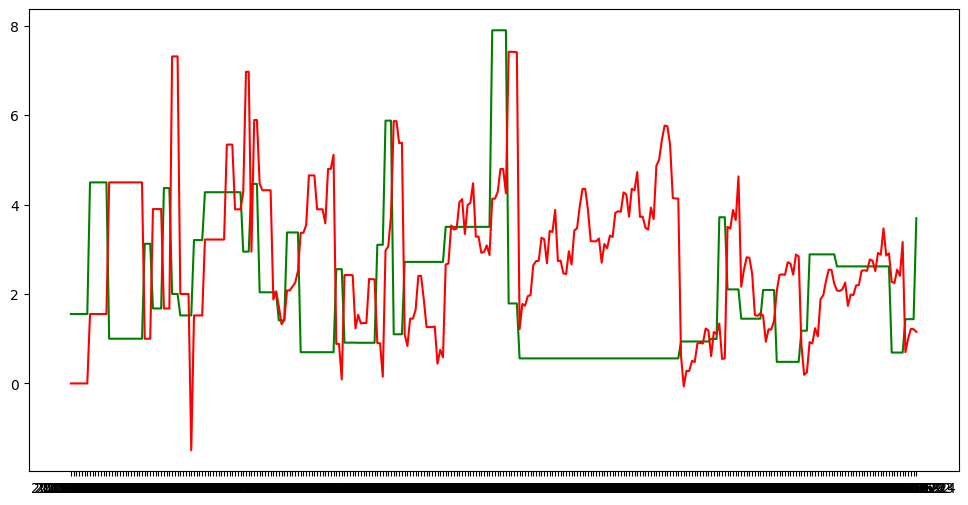

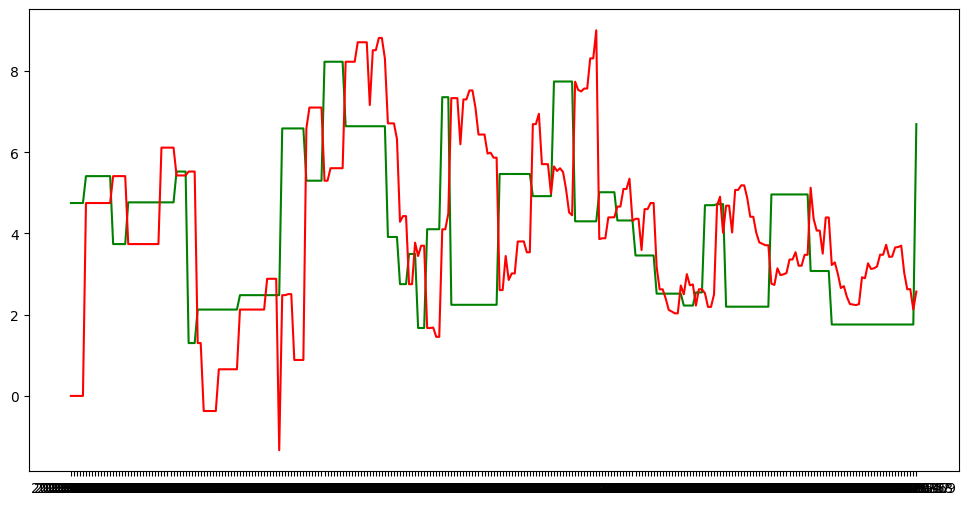

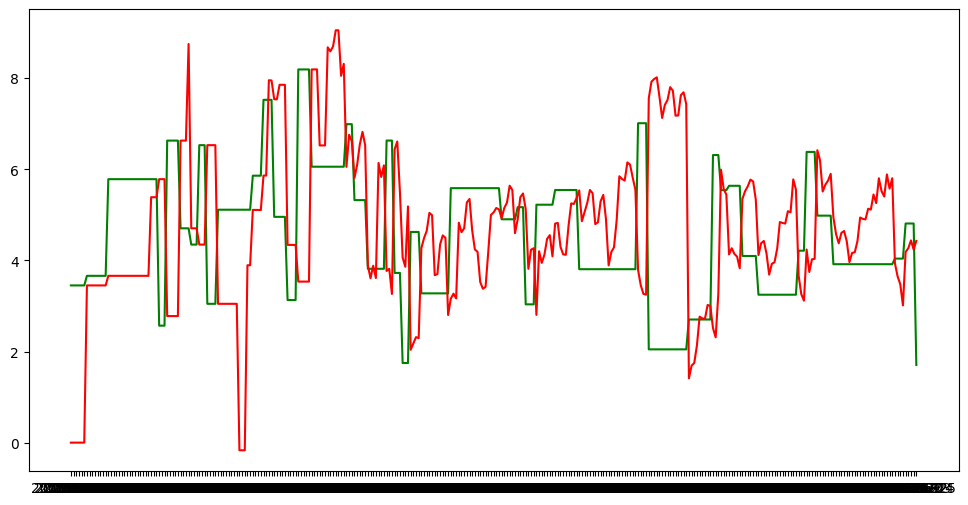

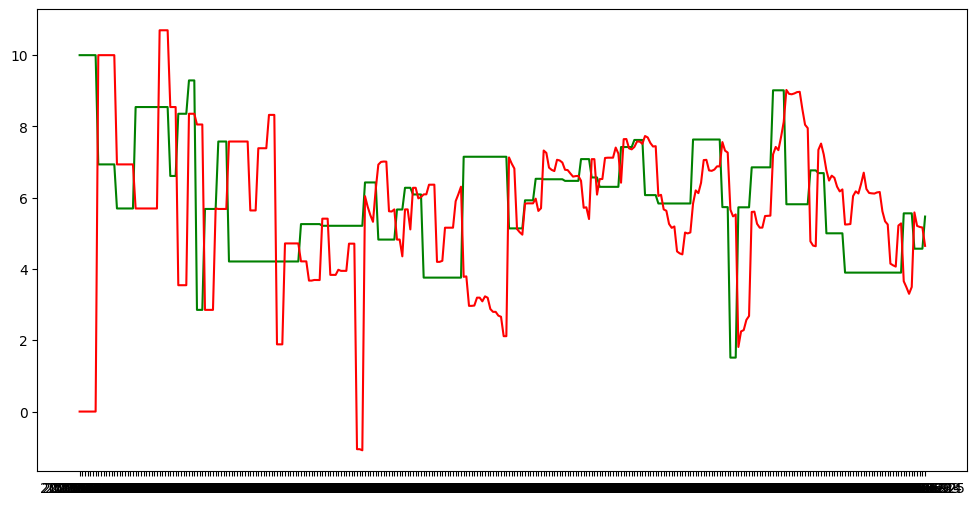

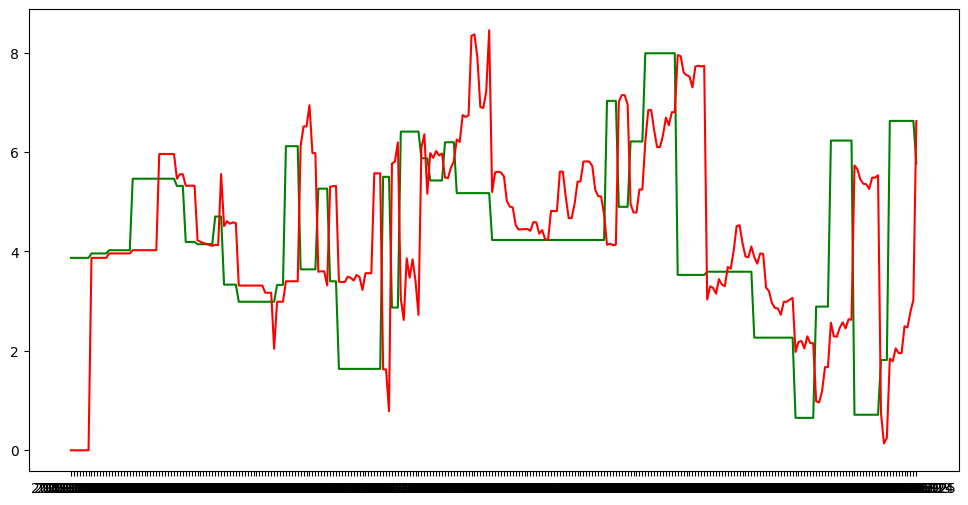

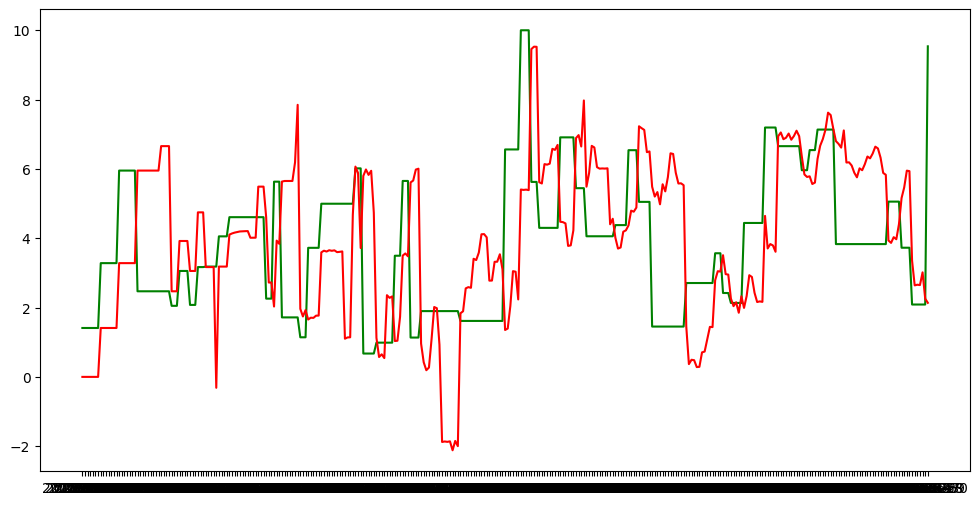

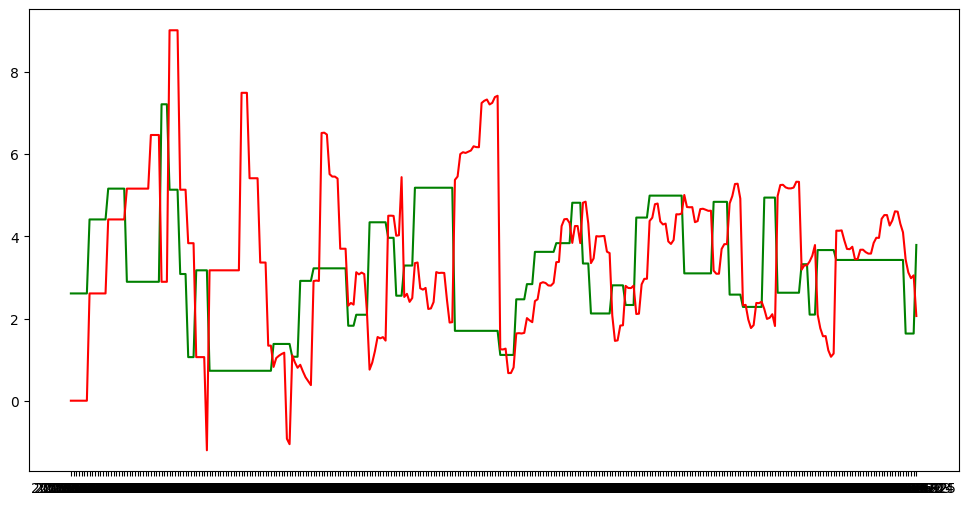

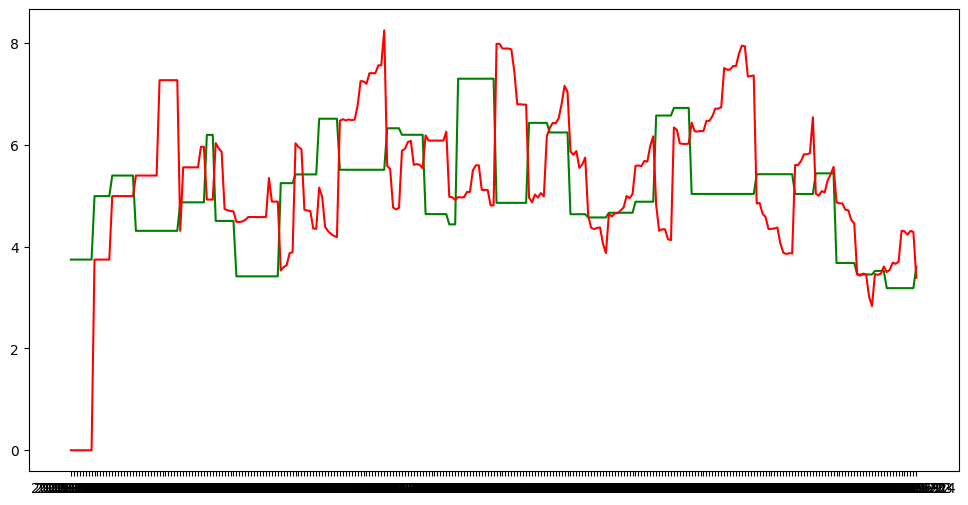

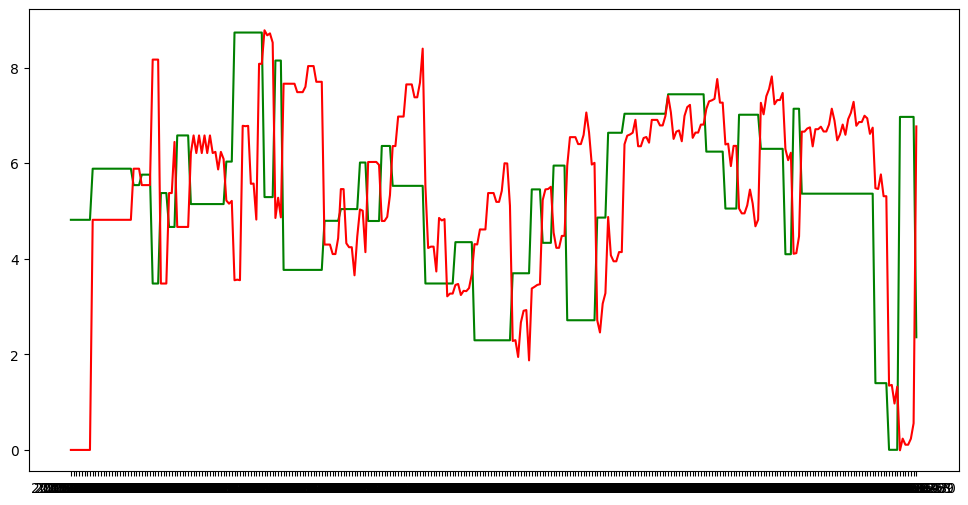

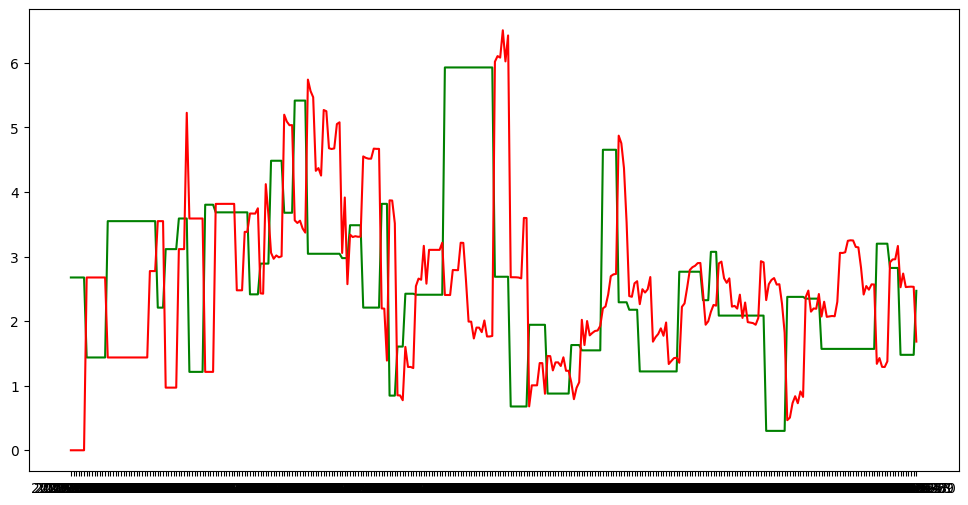

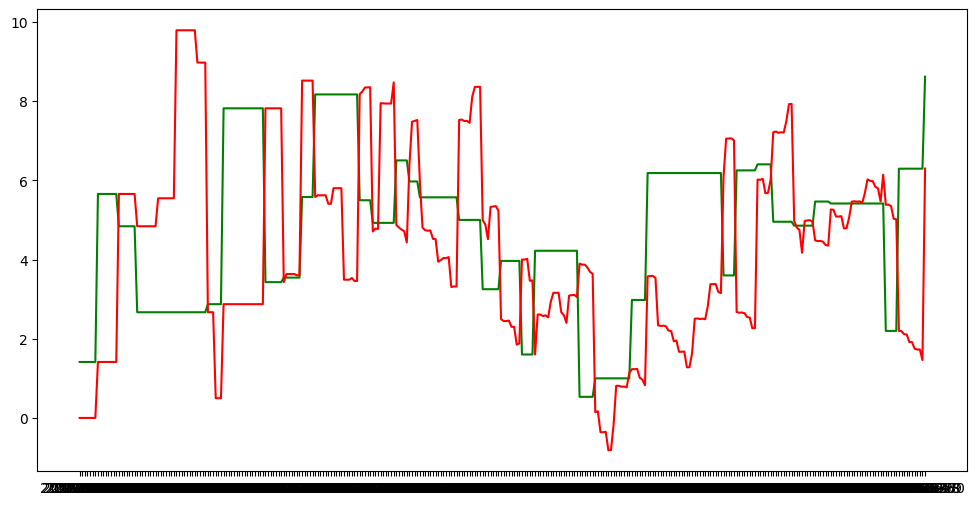

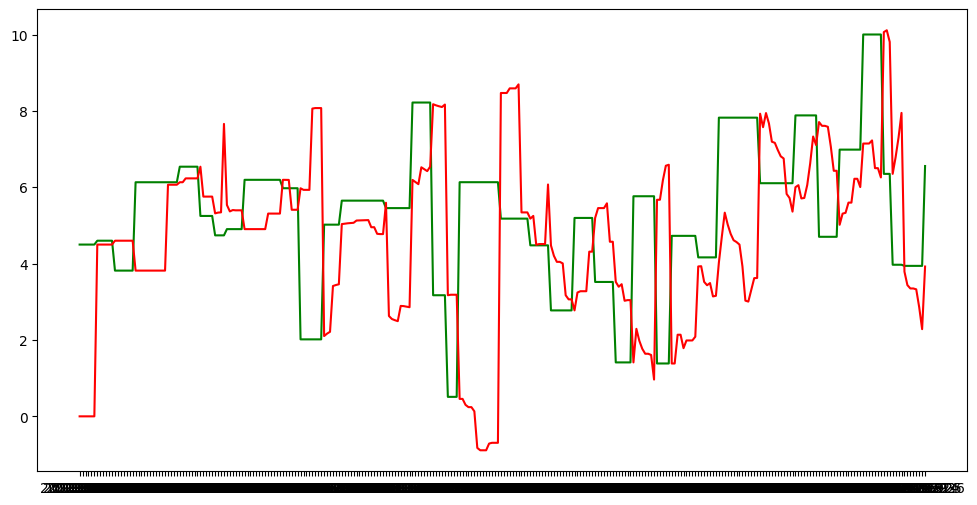

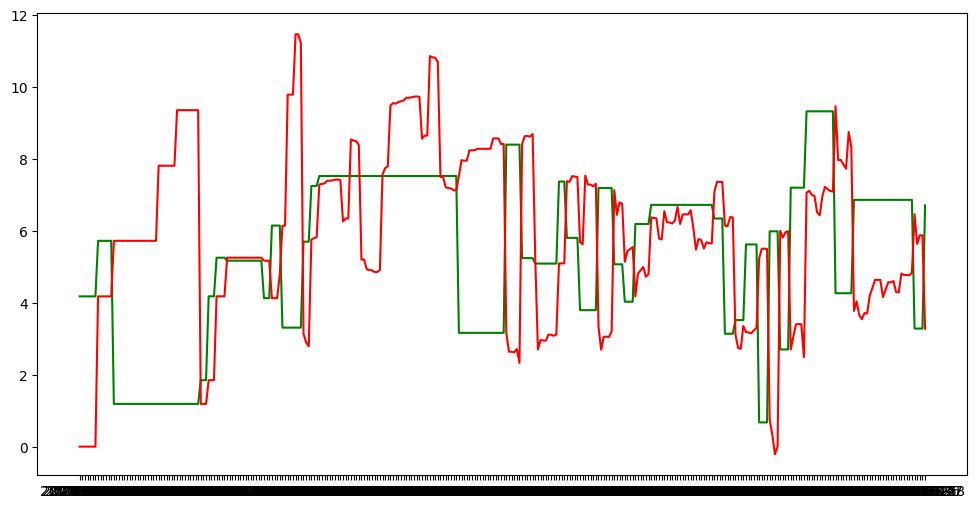

In [ ]:
df = pd.read_csv("processed\data_processed_final.csv")


# coger un jugador
jugadores = df["Player"].unique()

maes = []
medianas = []
for jugador in jugadores:
    df = pd.read_csv("processed\data_processed_final.csv")
    print(f"---------------------------{jugador}----------------------------")
    df = df[df["Player"] == jugador]


    # Identificar los días de partido: cambio en last_performance
    df['is_match_day'] = df['last_performance'].diff().ne(0).astype(int)

    # Crear un identificador para cada intervalo
    df['interval_id'] = df['is_match_day'].cumsum()

    # Crear un identificador para cada intervalo
    intervals = [group for _, group in df.groupby('interval_id')]


    pred_history = [0] * len(intervals[0]) 

    # Entrenamiento y predicción por intervalos
    for i in range(1, len(intervals)):
        # Crear datos de entrenamiento (intervalos hasta n-1)
        train_intervals = pd.concat(intervals[:i], ignore_index=True)

        y_train = train_intervals['last_performance'].to_list()
        #print(len(y_train))
        exog_train = train_intervals['Sentimientos_acumulado'].to_list()
        #print(len(exog_train))

        
        len_to_predict = len(intervals[i])
        #print(len_to_predict)
        last_exog = exog_train[-1]
        # hacer una lista de longitud len_to_predict con el último valor de exog_train
        pred_exog = [last_exog] * len_to_predict

        model = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
        model_fit = model.fit()

        # Hacer predicciones
        y_pred = model_fit.forecast(steps=len_to_predict, exog=pred_exog)

        # Guardar las predicciones
        pred_history.extend(y_pred)
        
        
    plt.figure(figsize=(12, 6))
    plt.plot(df['Fecha'], df['last_performance'], label='Real', color='green')
    plt.plot(df['Fecha'], pred_history, label='Predicción', color='red')

        # calcular el error cogiendo el dato real de un dia de partido con el ultimo dato predicho antes del siguiente partido
    real = df['last_performance'].to_list()

    errores = []

    print(len(real), len(pred_history))

    for i in range(len(real)-1):
        if real[i+1] != real[i]:
            errores.append(abs(real[i+1]-pred_history[i+1]))


    print(f"Error medio: {np.mean(errores)}")
    print(f"Mediana de errores: {np.median(errores)}")
    maes.append(np.mean(errores))
    medianas.append(np.median(errores))



---------------------------Ferran----------------------------
310 310
Error medio: 1.8828368878387698
Mediana de errores: 1.5716806029907455
---------------------------Gerard Moreno----------------------------
281 281
Error medio: 1.8377793457066933
Mediana de errores: 1.588438497209463
---------------------------Griezmann----------------------------
317 317
Error medio: 1.8134264949478485
Mediana de errores: 1.731575963238173
---------------------------Koundé----------------------------
318 318
Error medio: 1.647745701146653
Mediana de errores: 1.381402648033811
---------------------------Kubo----------------------------
288 288
Error medio: 1.6913722809024527
Mediana de errores: 1.3349266165945517
---------------------------Lamine Yamal----------------------------
323 323
Error medio: 1.9368035929216754
Mediana de errores: 1.423923959397891
---------------------------Lewandowski----------------------------
318 318
Error medio: 1.5146746632392531
Mediana de errores: 1.4080569297589194

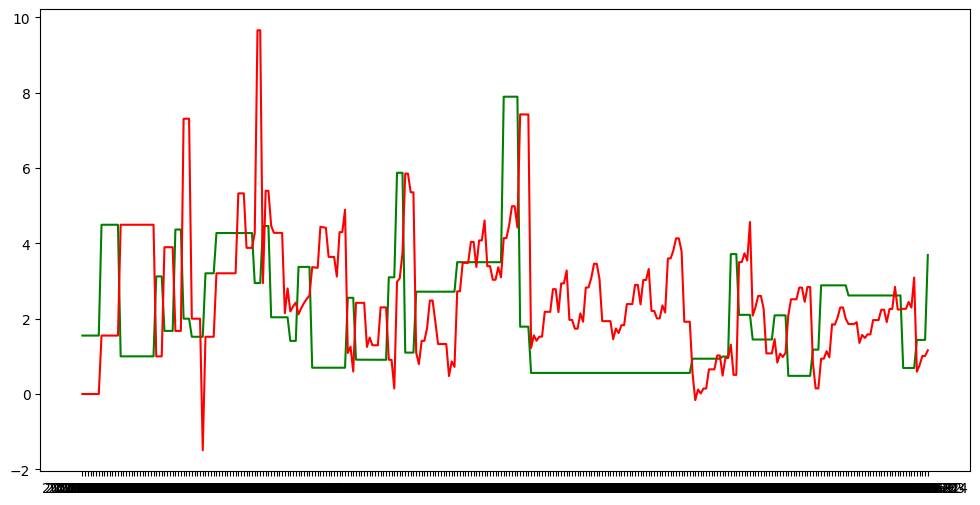

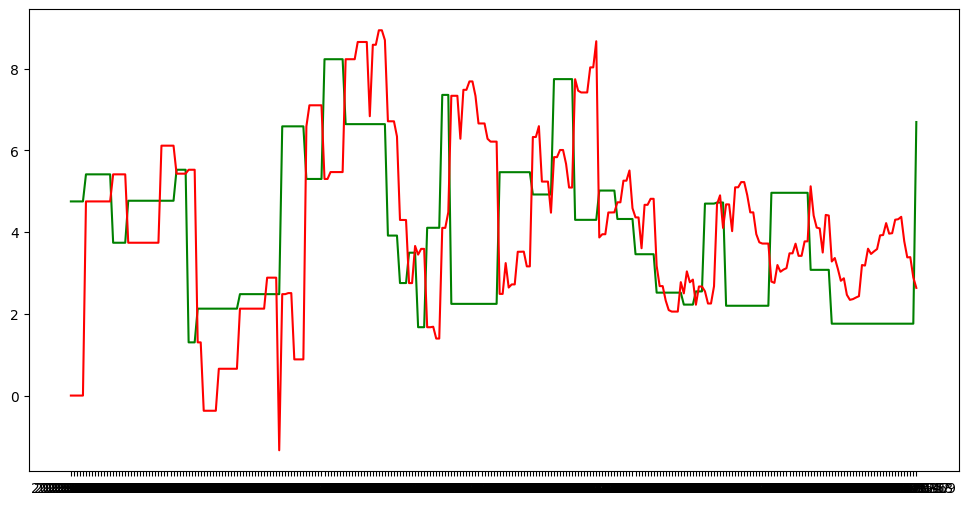

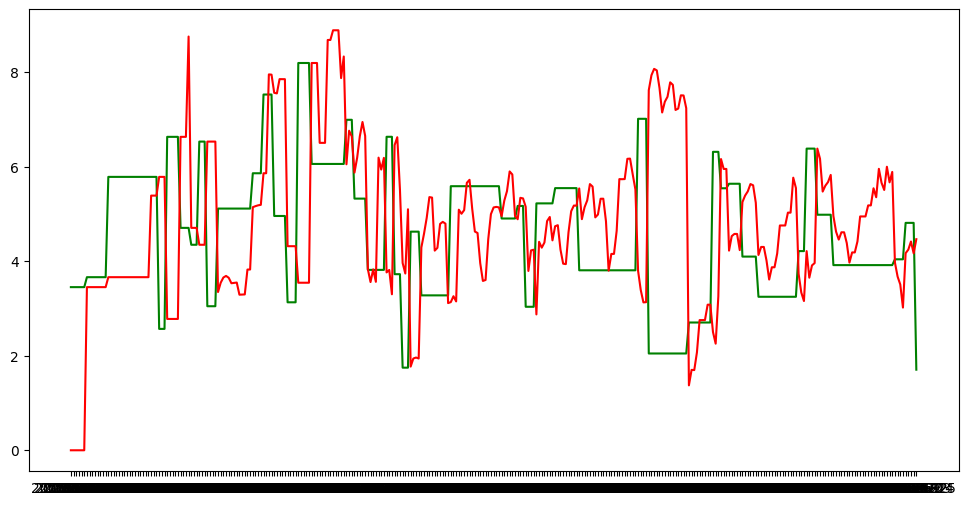

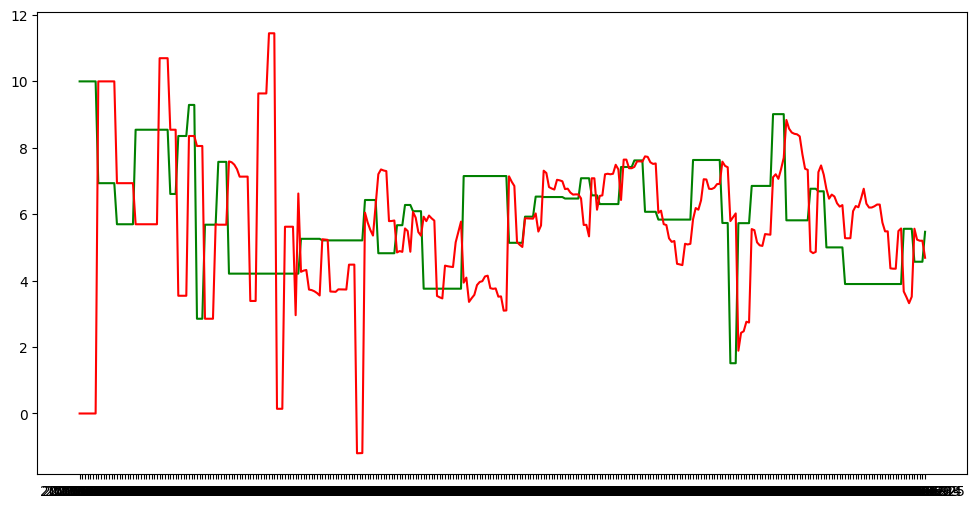

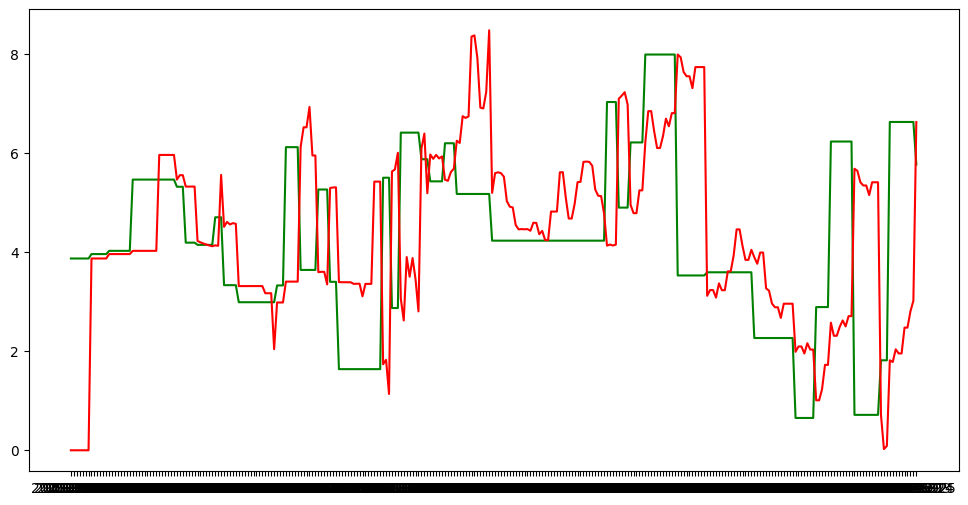

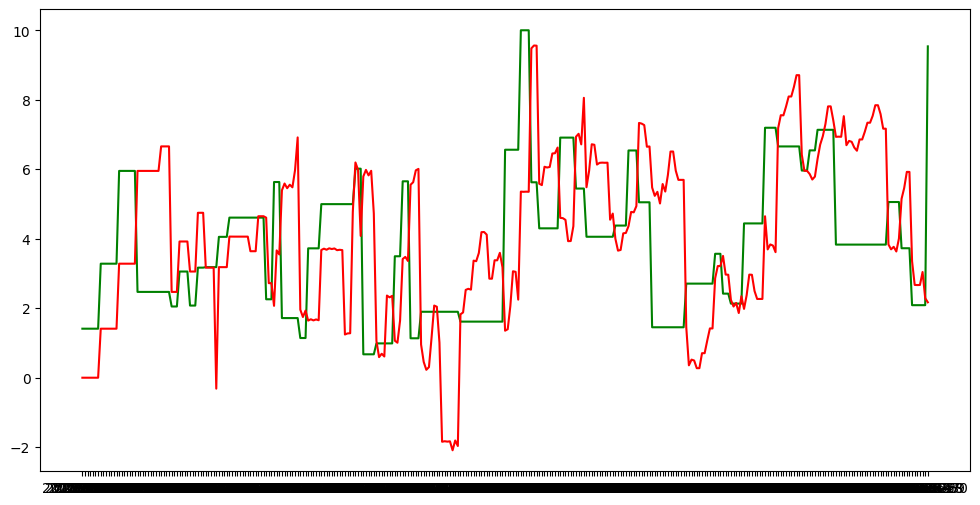

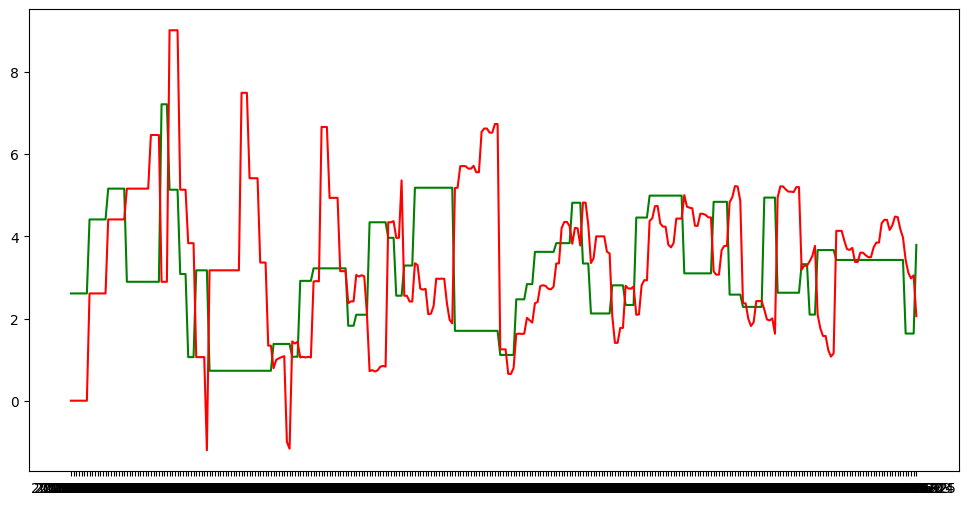

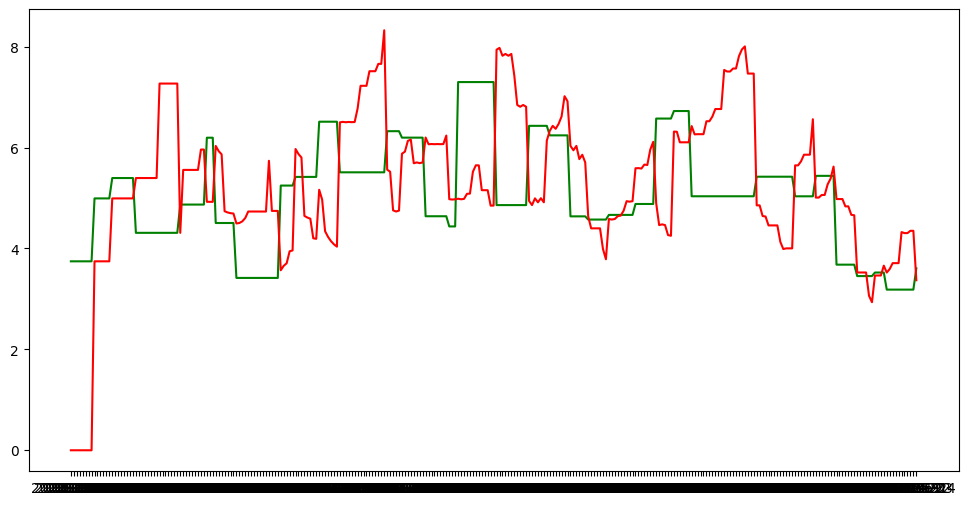

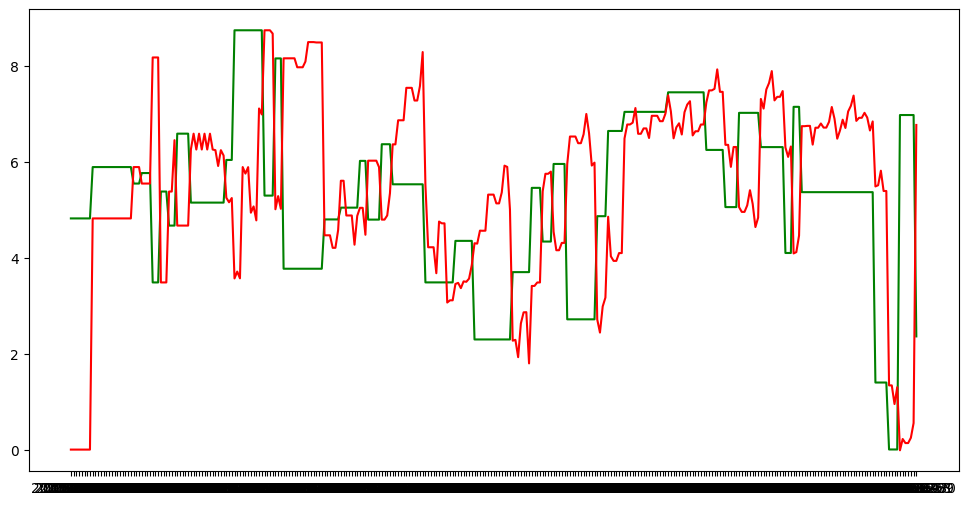

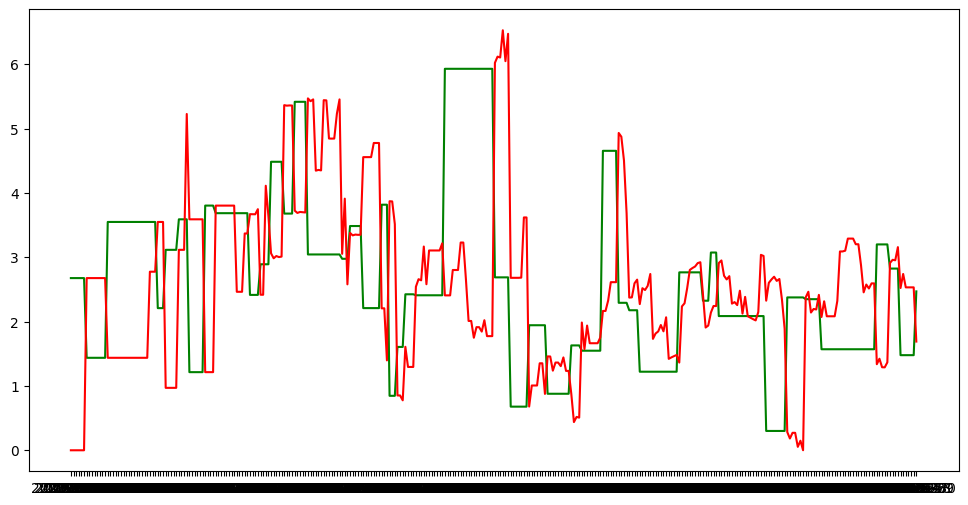

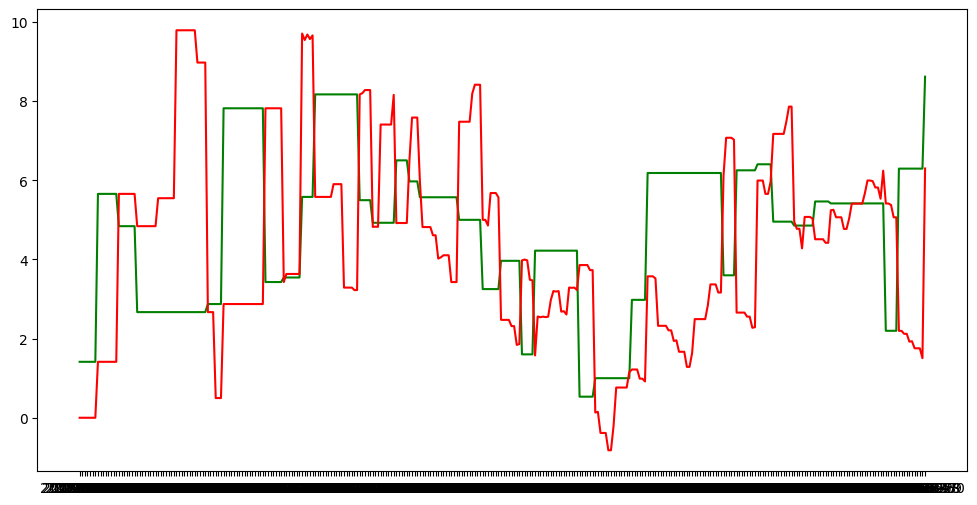

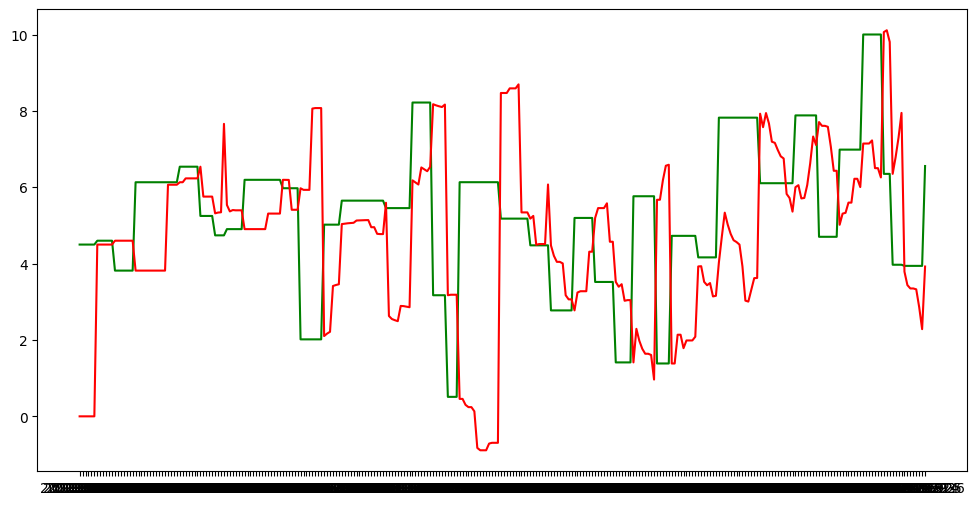

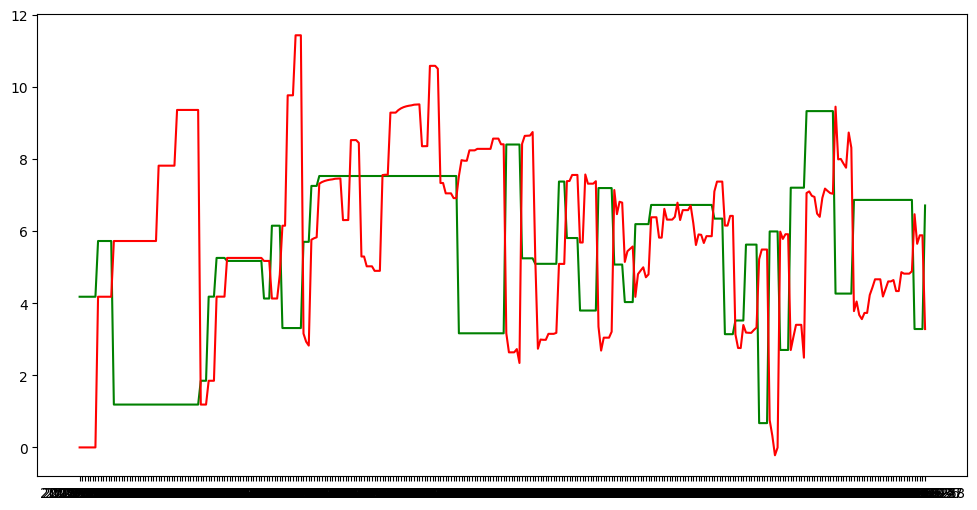

In [69]:
df = pd.read_csv("processed\data_processed_final.csv")


# coger un jugador
jugadores = df["Player"].unique()

maes = []
medianas = []
for jugador in jugadores:
    df = pd.read_csv("processed\data_processed_final.csv")
    print(f"---------------------------{jugador}----------------------------")
    df = df[df["Player"] == jugador]


    # Identificar los días de partido: cambio en last_performance
    df['is_match_day'] = df['last_performance'].diff().ne(0).astype(int)

    # Crear un identificador para cada intervalo
    df['interval_id'] = df['is_match_day'].cumsum()

    # Crear un identificador para cada intervalo
    intervals = [group for _, group in df.groupby('interval_id')]


    pred_history = [0] * len(intervals[0]) 

    # Entrenamiento y predicción por intervalos
    for i in range(1, len(intervals)):
        # Crear datos de entrenamiento (intervalos hasta n-1)
        train_intervals = pd.concat(intervals[:i], ignore_index=True)

        y_train = train_intervals['last_performance'].to_list()
        #print(len(y_train))

        
        len_to_predict = len(intervals[i])


        model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
        model_fit = model.fit()

        # Hacer predicciones
        y_pred = model_fit.forecast(steps=len_to_predict)

        # Guardar las predicciones
        pred_history.extend(y_pred)
        
        
    plt.figure(figsize=(12, 6))
    plt.plot(df['Fecha'], df['last_performance'], label='Real', color='green')
    plt.plot(df['Fecha'], pred_history, label='Predicción', color='red')

        # calcular el error cogiendo el dato real de un dia de partido con el ultimo dato predicho antes del siguiente partido
    real = df['last_performance'].to_list()

    errores = []

    print(len(real), len(pred_history))

    for i in range(len(real)-1):
        if real[i+1] != real[i]:
            errores.append(abs(real[i+1]-pred_history[i+1]))


    print(f"Error medio: {np.mean(errores)}")
    print(f"Mediana de errores: {np.median(errores)}")
    maes.append(np.mean(errores))
    medianas.append(np.median(errores))

